**Topic:** Kitsune Network Attack Classification

Advisor: Dr. Nahid Majd

Tips to run the notebook : All sections prior to feature selection can be run directly without expanding them. For feature selection, expand each section, select the model of your choice and run the 'Fit Model #' section (also run feature selection in case of ANOVA). For performing the hyperparameter tuning again, run the 'Tuning Hyperparameters' section. 'Tuning Hyperparameters' section need not be run everytime since the models are already defined after tuning hyperparameters and tuning hyperparameters takes hours of time.

# Loading the Libraries and Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, multilabel_confusion_matrix, classification_report, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from google.colab import drive
import warnings
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

# Global Functions and Values

In [ ]:
# function to return metrics
def get_model_metrics(model_name, y_true, y_pred):
    metrics = {}
    metrics['Model'] = model_name
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['F1-Score'] = f1_score(y_true, y_pred)

    return metrics

In [ ]:
# list to metrics of all tables
metrics_table = list()

# Load Dataset

## Load dataset from my Google
6500 Benign & 6500 Malicious for each attack. 13000 * 9 = 117000 rows

In [ ]:
drive.mount('/content/drive')

data1 = pd.read_csv('/content/drive/My Drive/kitsune_network_classification/kitsune_sample/Active_Wiretap_sample.csv')
data2 = pd.read_csv('/content/drive/My Drive/kitsune_network_classification/kitsune_sample/ARP_MitM_sample.csv')
data3 = pd.read_csv('/content/drive/My Drive/kitsune_network_classification/kitsune_sample/Fuzzing_sample.csv')
data4 = pd.read_csv('/content/drive/My Drive/kitsune_network_classification/kitsune_sample/Mirai_sample.csv')
data5 = pd.read_csv('/content/drive/My Drive/kitsune_network_classification/kitsune_sample/OS_Scan_sample.csv')
data6 = pd.read_csv('/content/drive/My Drive/kitsune_network_classification/kitsune_sample/SSDP_Flood_sample.csv')
data7 = pd.read_csv('/content/drive/My Drive/kitsune_network_classification/kitsune_sample/SSL_Renegotiation_sample.csv')
data8 = pd.read_csv('/content/drive/My Drive/kitsune_network_classification/kitsune_sample/SYN_DoS_sample.csv')
data9 = pd.read_csv('/content/drive/My Drive/kitsune_network_classification/kitsune_sample/Video_Injection_sample.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Displaying the contents of the file

## Merge the datasets
Each Dataset includes 117 columns(features) in it.

In [ ]:
# displaying the contents of the XLSX file
data1 = data1.drop(['Unnamed: 0'], axis=1)
data2 = data2.drop(['Unnamed: 0'], axis=1)
data3 = data3.drop(['Unnamed: 0'], axis=1)
data4 = data4.drop(['Unnamed: 0'], axis=1)
data5 = data5.drop(['Unnamed: 0'], axis=1)
data6 = data6.drop(['Unnamed: 0'], axis=1)
data7 = data7.drop(['Unnamed: 0'], axis=1)
data8 = data8.drop(['Unnamed: 0'], axis=1)
data9 = data9.drop(['Unnamed: 0'], axis=1)

In [ ]:
data1.columns = ['feature_'+str(i) for i in range(0,116)]
data2.columns = ['feature_'+str(i) for i in range(0,116)]
data3.columns = ['feature_'+str(i) for i in range(0,116)]
data4.columns = ['feature_'+str(i) for i in range(0,116)]
data5.columns = ['feature_'+str(i) for i in range(0,116)]
data6.columns = ['feature_'+str(i) for i in range(0,116)]
data7.columns = ['feature_'+str(i) for i in range(0,116)]
data8.columns = ['feature_'+str(i) for i in range(0,116)]
data9.columns = ['feature_'+str(i) for i in range(0,116)]

In [ ]:
data1['attack']=1
data2['attack']=2
data3['attack']=3
data4['attack']=4
data5['attack']=5
data6['attack']=6
data7['attack']=7
data8['attack']=8
data9['attack']=9

df = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9])
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack
0,0,437.563571,1351.173440,164944.147470,704.662341,1346.377355,171567.380491,2015.481616,1340.104694,180591.333200,...,0.000000,0.000000,14619.690111,1340.817992,426.244346,1340.817992,181684.242397,0.000000,0.000000,1
1,0,439.400772,1353.797591,169482.215618,664.787025,1349.365313,172807.896305,1778.983748,1345.597490,175424.792358,...,0.000000,0.000000,27623.284974,1341.130387,425.505210,1341.130387,181054.683719,0.000000,0.000000,1
2,0,301.954598,1326.778917,195161.714632,516.156670,1328.096839,194734.903426,1627.891901,1333.284001,190191.966096,...,0.000000,0.000000,27719.303452,1340.702953,426.233017,1340.702953,181674.584821,0.000000,0.000000,1
3,0,209.397726,1310.361807,134531.989365,330.110196,1307.842310,134119.008016,915.314652,1302.818197,136248.289802,...,0.000217,0.000057,21963.740888,1227.110059,238.965895,1228.576780,57104.698984,0.977038,0.002521,1
4,0,374.712064,1337.501748,193072.940286,643.180734,1340.639453,188892.985689,1952.407728,1342.840191,183590.716111,...,0.000000,0.000000,25070.859670,1341.077561,425.518245,1341.077561,181065.776502,0.000000,0.000000,1


# Data Preprocessing

**Importance of Data Preprocessing stage**


1.   Different ML models have different required input data (numerical data, images in specific format, etc). Without the right data, nothing will work.
2.   Because of “bad” data, ML models will not give any useful results, or even may give wrong answers, that may lead to wrong decisions (GIGO principle).
3.   The higher the quality of the data, the less data is needed.



## Reset Column Names

In [ ]:
df.columns = ['feature_'+str(i) for i in range(len(df.columns))]
df.columns.values[0]='label'
df.columns.values[-1]='attack'

cols = list(df)[1:]
cols.append('label')
# reorder the columns
df = df[cols]

df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
0,437.563571,1351.173440,164944.147470,704.662341,1346.377355,171567.380491,2015.481616,1340.104694,180591.333200,19696.823892,...,0.000000,14619.690111,1340.817992,426.244346,1340.817992,181684.242397,0.000000,0.000000,1,0
1,439.400772,1353.797591,169482.215618,664.787025,1349.365313,172807.896305,1778.983748,1345.597490,175424.792358,16934.947924,...,0.000000,27623.284974,1341.130387,425.505210,1341.130387,181054.683719,0.000000,0.000000,1,0
2,301.954598,1326.778917,195161.714632,516.156670,1328.096839,194734.903426,1627.891901,1333.284001,190191.966096,16808.639673,...,0.000000,27719.303452,1340.702953,426.233017,1340.702953,181674.584821,0.000000,0.000000,1,0
3,209.397726,1310.361807,134531.989365,330.110196,1307.842310,134119.008016,915.314652,1302.818197,136248.289802,8789.030170,...,0.000057,21963.740888,1227.110059,238.965895,1228.576780,57104.698984,0.977038,0.002521,1,0
4,374.712064,1337.501748,193072.940286,643.180734,1340.639453,188892.985689,1952.407728,1342.840191,183590.716111,19649.295311,...,0.000000,25070.859670,1341.077561,425.518245,1341.077561,181065.776502,0.000000,0.000000,1,0


In [ ]:
df.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
count,117000.000000,117000.000000,117000.000000,117000.000000,117000.000000,117000.000000,117000.000000,117000.000000,117000.000000,117000.000000,...,117000.000000,117000.000000,117000.000000,117000.000000,117000.000000,117000.000000,117000.000000,117000.000000,117000.000,117000.000000
mean,632.927459,944.682217,152749.689597,1037.492409,945.527732,152362.295196,2987.327875,947.024861,152322.699232,22886.179308,...,-0.002263,18516.991440,948.598179,241.370957,1017.556227,93458.112381,-27.654504,-0.004878,5.000,0.500000
std,1649.643426,527.959583,139117.857133,2733.138865,527.806407,138466.017899,8022.941169,527.020243,137741.140321,64259.386087,...,0.036910,11247.115219,582.065968,180.809747,543.403484,78757.857280,652.983175,0.045519,2.582,0.500002
min,1.000000,52.000000,0.000000,1.000000,52.000000,0.000000,1.000000,52.000000,0.000000,1.000000,...,-1.173162,1.000000,52.000000,0.000000,52.000000,0.000000,-43015.371203,-1.196685,1.000,0.000000
25%,63.886048,694.590792,19510.335316,101.802505,696.264896,25183.720502,290.074838,701.165848,32896.218931,2805.251464,...,0.000000,8539.127259,152.298144,0.000099,207.053569,80.326731,0.000000,0.000000,3.000,0.000000
50%,147.098190,1292.117808,157239.311220,242.196879,1297.056774,159960.080431,609.304467,1297.910557,169523.976226,5645.736249,...,0.000000,24469.386745,1338.671897,231.435043,1339.708402,55290.384676,0.000000,0.000000,5.000,0.500000
75%,356.871271,1340.033871,197307.307060,610.045123,1340.372927,192693.877941,1897.120978,1340.022301,187207.576846,14949.850605,...,0.000000,27932.026643,1341.418471,425.199199,1341.589596,180794.792407,0.000000,0.000000,7.000,1.000000
max,7454.051189,1508.200921,480965.160234,12411.452365,1477.552922,482659.091673,37171.840910,1470.469551,477371.792060,354098.275485,...,0.840819,44782.487299,1454.455765,691.812740,1454.455765,478604.867678,34516.520159,0.954630,9.000,1.000000


## Handling missing data

Using `isna().sum()` function gives the sum of the null values preset in the dataset column-wise.

`fillna()` function will fill NA/NaN or 0 values in place of null spaces.

`df["colName"].fillna("replacingValue", inplace = True)`

In [ ]:
# check null values
df_null = df[df.isna().any(axis=1)]
df_null

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label


**Observation:** remove these 4 rows with null Values Found

In [ ]:
df = df.dropna()
df_null = df[df.isna().any(axis=1)]
df_null

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label


In [ ]:
df.shape

(117000, 117)

**Observation:** There is no missing data. Total: 117000 rows.

# Data Transformation

## Standardization/Normalization

**min_max scaler** is a way to get data in the range 0 to 1

**StandardScaler** if we need -1 to 1 range. Scale each variable to have a mean of 0 and a standard deviation of 1

We use scaling so that each variable has equal importance when fitting the k-means algorithm. Otherwise, the variables with the widest ranges would have too much influence.

In [ ]:
# import required modules
from sklearn.preprocessing import MinMaxScaler

# create scaled DataFrame where each variable has mean of 0 and standard dev of 1
df_scaled = MinMaxScaler().fit_transform(df)

# view first five rows of scaled DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=list(df))
df_scaled.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
0,0.058575,0.892166,0.342944,0.056699,0.907983,0.355463,0.054195,0.908095,0.378303,0.055623,...,0.582509,0.326445,0.918972,0.616127,0.918972,0.379612,0.554809,0.556257,0.0,0.0
1,0.058822,0.893968,0.352379,0.053486,0.910079,0.358033,0.047833,0.911967,0.367480,0.047823,...,0.582509,0.616824,0.919195,0.615058,0.919195,0.378297,0.554809,0.556257,0.0,0.0
2,0.040380,0.875414,0.405771,0.041510,0.895159,0.403463,0.043768,0.903286,0.398415,0.047466,...,0.582509,0.618968,0.918890,0.616110,0.918890,0.379592,0.554809,0.556257,0.0,0.0
3,0.027961,0.864140,0.279713,0.026519,0.880951,0.277875,0.024598,0.881808,0.285413,0.024818,...,0.582537,0.490442,0.837895,0.345420,0.838940,0.119315,0.554821,0.557429,0.0,0.0
4,0.050142,0.882778,0.401428,0.051745,0.903958,0.391359,0.052498,0.910023,0.384586,0.055488,...,0.582509,0.559826,0.919157,0.615077,0.919157,0.378320,0.554809,0.556257,0.0,0.0


## Handling (drop) outliers
Note: dropping is only one of techniques to handle with outliers

### Z-Score

* A **z-score** measures how many standard deviations a data point is from the mean in a distribution.
* A normal distribution is shown below and it is estimated that
 * outliers_threshold = 1: 68% of the data points lie between +/- 1 standard deviation.
 * outliers_threshold = 2: 95% of the data points lie between +/- 2 standard deviation
 * outliers_threshold = 3: 99.7% of the data points lie between +/- 3 standard deviation
 * outliers_threshold = 4: 99.9% of the data points lie between +/- 4 standard deviation
* We are removing all the rows above this outlier threshold

In [ ]:
from scipy import stats
z_scores = np.abs(stats.zscore(df_scaled, nan_policy='omit'))
z_scores.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
0,0.118428,0.769932,0.087656,0.121776,0.759467,0.138699,0.121134,0.745857,0.205231,0.049633,...,0.061310,0.346517,0.673844,1.022479,0.594886,1.120225,0.042351,0.107169,1.549193,1.0
1,0.117315,0.774902,0.120276,0.136366,0.765128,0.147659,0.150612,0.756279,0.167722,0.092613,...,0.061310,0.809659,0.674380,1.018391,0.595461,1.112231,0.042351,0.107169,1.549193,1.0
2,0.200634,0.723726,0.304865,0.190747,0.724832,0.306016,0.169444,0.732915,0.274932,0.094579,...,0.061310,0.818197,0.673646,1.022416,0.594674,1.120102,0.042351,0.107169,1.549193,1.0
3,0.256741,0.692631,0.130952,0.258818,0.686456,0.131753,0.258262,0.675107,0.116701,0.219380,...,0.062852,0.306458,0.478491,0.013302,0.388333,0.461587,0.043847,0.162556,1.549193,1.0
4,0.156529,0.744037,0.289851,0.144271,0.748595,0.263825,0.128996,0.751047,0.227007,0.050372,...,0.061310,0.582718,0.674290,1.018463,0.595364,1.112372,0.042351,0.107169,1.549193,1.0


In [ ]:
outliers_threshold = 3
mask = (z_scores <= outliers_threshold).all(axis=1)
print(f"The number of outlier rows is {len(mask[mask == False])} from total {df_scaled.shape[0]} rows")

The number of outlier rows is 12920 from total 117000 rows


**Observation:** No. of outlier rows = 12920 from total 117000 rows

In [ ]:
# remove these outliers
df_zscored = df_scaled[mask]
df_zscored.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
0,0.058575,0.892166,0.342944,0.056699,0.907983,0.355463,0.054195,0.908095,0.378303,0.055623,...,0.582509,0.326445,0.918972,0.616127,0.918972,0.379612,0.554809,0.556257,0.0,0.0
1,0.058822,0.893968,0.352379,0.053486,0.910079,0.358033,0.047833,0.911967,0.367480,0.047823,...,0.582509,0.616824,0.919195,0.615058,0.919195,0.378297,0.554809,0.556257,0.0,0.0
3,0.027961,0.864140,0.279713,0.026519,0.880951,0.277875,0.024598,0.881808,0.285413,0.024818,...,0.582537,0.490442,0.837895,0.345420,0.838940,0.119315,0.554821,0.557429,0.0,0.0
4,0.050142,0.882778,0.401428,0.051745,0.903958,0.391359,0.052498,0.910023,0.384586,0.055488,...,0.582509,0.559826,0.919157,0.615077,0.919157,0.378320,0.554809,0.556257,0.0,0.0
5,0.049346,0.902047,0.350996,0.046707,0.916726,0.354626,0.045346,0.914311,0.367207,0.047588,...,0.582509,0.608242,0.918955,0.615510,0.918955,0.378852,0.554809,0.556257,0.0,0.0


In [ ]:
# Now have 15488 rows of clean data
df_zscored.shape

(104080, 117)

# Model Building

In [ ]:
# split the dataset into training and testing sets
X = df_scaled.drop(['attack', 'label'], axis=1) # features
y = df_scaled['label'] # target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

## Feature Selection

### Correltion Analysis & Visualization

The Result of the corr() method is a table with a lot of numbers that represents how well the relationship is between two columns.

The number varies from -1 to 1.
* 1 means that there is a 1 to 1 relationship (a perfect correlation), and for this data set, each time a value went up in the first column, the other one went up as well.
* 0.9 is also a good relationship, and if we increase one value, the other will probably increase as well.
* -0.9 would be just as good relationship as 0.9, but if we increase one value, the other will probably go down.
* 0.2 means NOT a good relationship, meaning that if one value goes up does not mean that the other will.

In [ ]:
len(list(df_scaled))

117

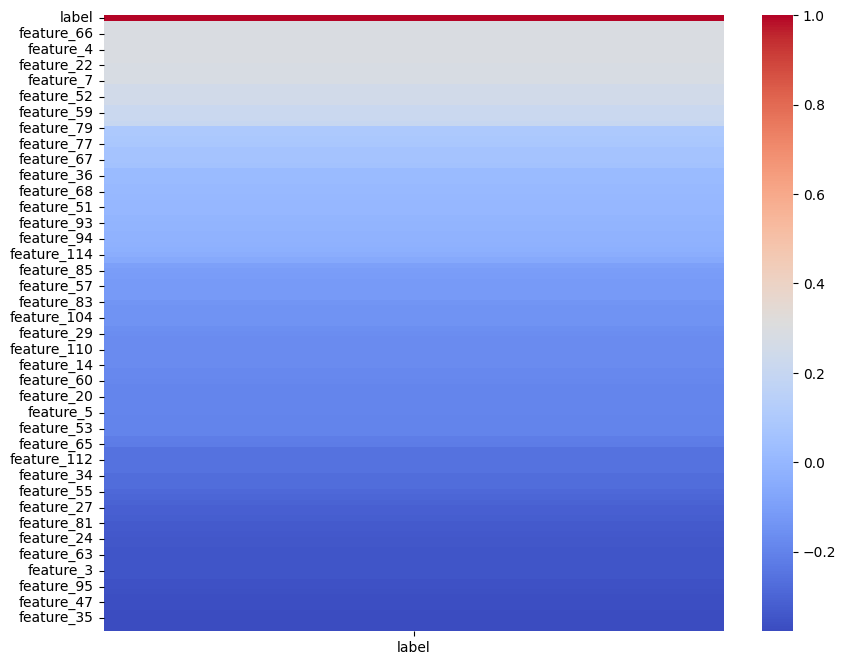

In [ ]:
# correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
corr = ((df_scaled.corr().iloc[:,-1]).sort_values(ascending=False)).to_frame()
sns.heatmap(corr, cmap="coolwarm")
plt.show()

**Observation:** Below is the list of columns with low correlation with the label. ie. (-0.3 < corr < 0.3) . These are not good candidates for predictions



### SelectKBest

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2

# feature selection and engineering
selector = SelectKBest(f_classif, k='all')
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [ ]:
dic = dict(zip(selector.feature_names_in_, selector.scores_))
print(dic)

{'feature_1': 7611.145095141901, 'feature_2': 3288.072588268256, 'feature_3': 11151.170047414867, 'feature_4': 7454.602227287389, 'feature_5': 3287.8656483502914, 'feature_6': 11085.113410039732, 'feature_7': 7051.696151012256, 'feature_8': 3252.752098545946, 'feature_9': 10832.675886539131, 'feature_10': 5402.724532832011, 'feature_11': 2916.7594399667314, 'feature_12': 9266.85709507781, 'feature_13': 3495.0502566928935, 'feature_14': 2527.768750618433, 'feature_15': 10319.710972788054, 'feature_16': 7619.452867729353, 'feature_17': 3285.2973526982532, 'feature_18': 11162.768639061092, 'feature_19': 7466.28452360348, 'feature_20': 3284.7885189523417, 'feature_21': 11094.136017077044, 'feature_22': 7076.0901079186015, 'feature_23': 3247.9914923171978, 'feature_24': 10819.500296130498, 'feature_25': 5476.94450183509, 'feature_26': 2885.732463114174, 'feature_27': 9011.098488421185, 'feature_28': 3980.9902850541257, 'feature_29': 2307.6924039766745, 'feature_30': 8350.46275297705, 'featu

In [ ]:
sort_dic = sorted(dic.items(), key=lambda x:x[1])
print(sort_dic)

[('feature_51', 0.041463482383639214), ('feature_37', 1.846865117635773), ('feature_44', 2.392538121018022), ('feature_86', 5.765141390952015), ('feature_93', 14.079435774625537), ('feature_68', 15.011759475441615), ('feature_87', 20.762446281266012), ('feature_50', 21.929526732817404), ('feature_36', 23.15405988977655), ('feature_71', 27.772789813618466), ('feature_100', 32.009675738252156), ('feature_43', 33.401557826311745), ('feature_94', 34.03497108908622), ('feature_101', 63.5024161517666), ('feature_107', 77.0383178085574), ('feature_114', 119.61052212300294), ('feature_108', 245.19005542463913), ('feature_74', 256.4486039593032), ('feature_67', 291.5417461021846), ('feature_70', 291.9953168254289), ('feature_73', 328.64154476606967), ('feature_77', 583.0854436766899), ('feature_76', 623.3389978824373), ('feature_80', 685.296481452748), ('feature_115', 741.8886011941507), ('feature_79', 742.5786700375953), ('feature_85', 985.2017485880364), ('feature_92', 1079.0828307450943), ('

In [ ]:
i = 0
for key, value in sort_dic:
    print(key, ": ", value)
    i += 1
print(i)

feature_51 :  0.041463482383639214
feature_37 :  1.846865117635773
feature_44 :  2.392538121018022
feature_86 :  5.765141390952015
feature_93 :  14.079435774625537
feature_68 :  15.011759475441615
feature_87 :  20.762446281266012
feature_50 :  21.929526732817404
feature_36 :  23.15405988977655
feature_71 :  27.772789813618466
feature_100 :  32.009675738252156
feature_43 :  33.401557826311745
feature_94 :  34.03497108908622
feature_101 :  63.5024161517666
feature_107 :  77.0383178085574
feature_114 :  119.61052212300294
feature_108 :  245.19005542463913
feature_74 :  256.4486039593032
feature_67 :  291.5417461021846
feature_70 :  291.9953168254289
feature_73 :  328.64154476606967
feature_77 :  583.0854436766899
feature_76 :  623.3389978824373
feature_80 :  685.296481452748
feature_115 :  741.8886011941507
feature_79 :  742.5786700375953
feature_85 :  985.2017485880364
feature_92 :  1079.0828307450943
feature_57 :  1110.4046077103637
feature_99 :  1187.2420195096793
feature_106 :  1200.9

**Observation:** This method is more objective and can potentially identify more relevant features than using correlation. However, it is important to choose the right value of k (number of features to select) and also to consider the possibility of overfitting.

## GridSearchCV

GridSearchCV trains and evaluates the model with all possible combinations of hyperparameters from the param_grid dictionary using cross-validation (cv=5), and returns the best set of hyperparameters that result in the highest score on the training data.

Using the best set of hyperparameters returned by GridSearchCV can potentially improve the performance of the model on unseen data. It helps to tune the model and prevent overfitting.

 * `grid_search.best_score_` returns the mean cross-validated score achieved by the best estimator found by GridSearchCV during the parameter tuning process.

This means that it returns the average performance of the model over all cross-validation folds when trained with the best hyperparameters found by the grid search. It is a useful metric to compare different models and hyperparameter settings to see which ones perform better

 * `grid_search.best_params_` returns a dictionary of the best combination of hyperparameters found by the GridSearchCV object during cross-validation. This dictionary contains the values of hyperparameters that achieved the best mean cross-validated score on the training set. These hyperparameters can then be used to instantiate and train a new model on the entire training set.

# Fit a Logistic Regression on the training dataset

## Tuning

In [ ]:
# train and evaluate logistic regression
metrics_table = list()
warnings.filterwarnings('ignore')

# define the parameter grid to search over
param_grid = {
    'penalty': ['none'],
    'C': [100],
    'solver': ['newton-cg']
}

# create an instance of the model
logreg = LogisticRegression()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, verbose=1)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 100, 'penalty': 'none', 'solver': 'newton-cg'}
Best score: 0.798998778998779


## Fit Model 1

In [ ]:
# create an instance of the model with the best parameters
best_logreg =LogisticRegression(**grid_search.best_params_)

# train the model on the training data
best_logreg.fit(X_train, y_train)

# calculate predictions on Model
y_pred_logreg = best_logreg.predict(X_test)

# get the Performance metrics by method created above
metric_logreg = get_model_metrics(model_name="LogisticRegression", y_true=y_test, y_pred=y_pred_logreg)

# add metric to global list for conclusive evaluation
metrics_table.append(metric_logreg)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_logreg, orient='index', columns=['Value'])

# ROC curve
proba_logreg = best_logreg.predict_proba(X_test)
fpr1, tpr1, threshold1 = roc_curve(y_test, proba_logreg[:,1], pos_label=1)
auc_score1 = roc_auc_score(y_test, proba_logreg[:,1])
print(auc_score1)

0.9007014033036821


## Confusion Table of Model 1

In [ ]:
# confusion matrix for Logistic Regression on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_logreg).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,16011,5636
1,1516,11937


# Fit a Decision Tree on the training dataset

## Tuning

In [ ]:
# define the parameter grid to search over
param_grid = {
    'criterion':['entropy'],
    'max_depth': [20],
    'min_samples_leaf': [9]
}

# create an instance of the model
dt = DecisionTreeClassifier()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 9}
Best score: 0.9566544566544566


## Fit Model 2

In [ ]:
# create an instance of the model with the best parameters
best_dt = DecisionTreeClassifier(**grid_search.best_params_)

# train the model on the training data
best_dt.fit(X_train, y_train)

# calculate predictions on Model
y_pred_dt = best_dt.predict(X_test)

# get the Performance metrics by method created above
metric_dt = get_model_metrics(model_name="DecisionTreeClassifier", y_true=y_test, y_pred=y_pred_dt)

# add metric to global list for conclusive evaluation
metrics_table.append(metric_dt)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_dt, orient='index', columns=['Value'])

# ROC curve
proba_dt = best_dt.predict_proba(X_test)
fpr2, tpr2, threshold2 = roc_curve(y_test, proba_dt[:,1], pos_label=1)
auc_score2 = roc_auc_score(y_test, proba_dt[:,1])
print(auc_score2)

0.9791843864531634


## Confusion Table of Model 2

In [ ]:
# confusion matrix for Decision Tree on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_dt).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,16645,544
1,882,17029


# Fit a Random Forest on the training dataset

## Tuning

In [ ]:
# define the parameter grid to search over
param_grid = {
    'criterion': ['entropy'],
    'n_estimators': [90],
    'max_depth': [20]
}
# create an instance of the model
rf = RandomForestClassifier()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 90}
Best score: 0.9661660561660561


## Fit Model 3

In [ ]:
# train and evaluate the model with the best hyperparameters
best_rf = RandomForestClassifier(**grid_search.best_params_)

# train the model on the training data
best_rf.fit(X_train, y_train)

# calculate predictions on Model
y_pred_rf = best_rf.predict(X_test)

# get the Performance metrics by method created above
metric_rf = get_model_metrics(model_name="RandomForestClassifier", y_true=y_test, y_pred=y_pred_rf)

# add metric to global list for conclusive evaluation
metrics_table.append(metric_rf)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_rf, orient='index', columns=['Value'])

# ROC curve
proba_rf = best_rf.predict_proba(X_test)
fpr3, tpr3, threshold3 = roc_curve(y_test, proba_rf[:,1], pos_label=1)
auc_score3 = roc_auc_score(y_test, proba_rf[:,1])
print(auc_score3)

0.9919698208684515


## Confusion Table of Model 3

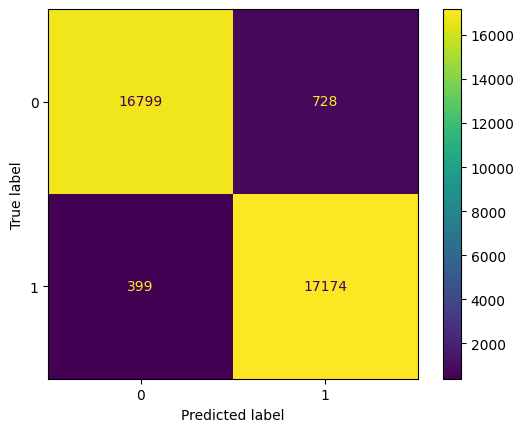

In [ ]:
# confusion matrix for Random Forest on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_rf).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

cm_data = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_data)
disp_rf.plot()
plt.show()

# Fit a Gradient Boosting on the training dataset

## Tuning

In [ ]:
# define the parameter grid to search over
param_grid = {
    "n_estimators": [90],
    "learning_rate":[0.1]
}

# create an instance of the model
gb = GradientBoostingClassifier()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'n_estimators': 90}
Best score: 0.9384493284493285


## Fit Model 4

In [ ]:
best_gb = GradientBoostingClassifier(**grid_search.best_params_)

# train the model on the training data
best_gb.fit(X_train, y_train)

# calculate predictions on Model
y_pred_gb = best_gb.predict(X_test)

# get the Performance metrics by method created above
metric_gb = get_model_metrics(model_name="GradientBoostingClassifier", y_true=y_test, y_pred=y_pred_gb)

# add metric to global list for conclusive evaluation
metrics_table.append(metric_gb)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_gb, orient='index', columns=['Value'])

# ROC curve
proba_gb = best_gb.predict_proba(X_test)
fpr4, tpr4, threshold4 = roc_curve(y_test, proba_gb[:,1], pos_label=1)
auc_score4 = roc_auc_score(y_test, proba_gb[:,1])
print(auc_score4)

0.9783200705556523


## Confusion Table of Model 4

In [ ]:
# confusion matrix for Gradient Boosting on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_gb).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,16785,1468
1,742,16105


# Fit a Support Vector Machine on the training dataset

## Tuning

In [ ]:
from sklearn.svm import SVC

# define the parameter grid to search over
param_grid = {
    'C': [1000],
    'kernel': ['rbf'],
    'gamma': [3.0]
}

# create an instance of the model
svm = SVC()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 1000, 'gamma': 3.0, 'kernel': 'rbf'}
Best score: 0.9420390720390721


## Fit Model 5

In [ ]:
# train the model on the training data with the best hyperparameters
best_svm = SVC(C=1000, kernel='rbf', gamma=3.0)
best_svm.fit(X_train, y_train)

# calculate predictions on Model
y_pred_svm = best_svm.predict(X_test)

# get the Performance metrics by method created above
metric_svm = get_model_metrics(model_name="SupportVectorMachine", y_true=y_test, y_pred=y_pred_svm)

# add metric to global list for conclusive evaluation
metrics_table.append(metric_svm)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_svm, orient='index', columns=['Value'])

,Value
Model,SupportVectorMachine
Accuracy,0.945128
Precision,0.938414
Recall,0.952939
F1-Score,0.945621


## Confusion Table of Model 5

In [ ]:
# confusion matrix for SVM on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_svm).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,16428,827
1,1099,16746


# Fit a **kNN** on the training dataset

## Tuning

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# define the parameter grid to search over
param_grid = {
    'n_neighbors': [6]
}

# create a KNeighborsClassifier object
knn = KNeighborsClassifier()

# use grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# print the best hyperparameters and their corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'n_neighbors': 6}
Best score: 0.8985470085470085


## Fit Model 6

In [ ]:
# use the best hyperparameters to train a new KNeighborsClassifier
best_knn = KNeighborsClassifier(**grid_search.best_params_)

# fit the model to the training data
best_knn.fit(X_train, y_train)

# make predictions on the test data
y_pred_kNN = best_knn.predict(X_test)

# get the Performance metrics by method created above
metric_kNN = get_model_metrics(model_name="K Neighbor Classifier", y_true=y_test, y_pred=y_pred_kNN)

# add metric to global list for conclusive evaluation
metrics_table.append(metric_kNN)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_kNN, orient='index', columns=['Value'])

# ROC curve
proba_knn = best_knn.predict_proba(X_test)
fpr6, tpr6, threshold6 = roc_curve(y_test, proba_knn[:,1], pos_label=1)
auc_score6 = roc_auc_score(y_test, proba_knn[:,1])
print(auc_score6)

0.9560957095303783


## Confusion Table of Model 6

In [ ]:
# confusion matrix for SVM on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_kNN).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,15915,1849
1,1612,15724


# Fit a XGBoost on the training dataset

## Tuning

In [ ]:
# define the parameter grid to search over
param_grid ={
    "n_estimators" : [90],
    "learning_rate": [0.1]
}

# create an instance of model
xgb_cl = xgb.XGBClassifier()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=xgb_cl, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'n_estimators': 90}
Best score: 0.9671672771672771


## Fit Model 7

In [ ]:
# use the best hyperparameters to train a new XGBoosting Classifier
best_xgb = xgb.XGBClassifier(**grid_search.best_params_)

# fit the model to the training data
best_xgb.fit(X_train, y_train)

# make predictions on the test data
y_pred_xgb = best_xgb.predict(X_test)

# get the Performance metrics by method created above
metric_xgb = get_model_metrics(model_name = "XGBoosting Classifier", y_true=y_test, y_pred=y_pred_xgb)

# add metric to global list for conclusion evaluation
metrics_table.append(metric_xgb)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_xgb, orient='index', columns=['Value'])

# ROC curve
proba_xgb = best_xgb.predict_proba(X_test)
fpr7, tpr7, threshold7 = roc_curve(y_test, proba_xgb[:,1], pos_label=1)
auc_score7 = roc_auc_score(y_test, proba_xgb[:,1])
print(auc_score7)

0.992360670639994


## Confusion Table of Model 7

In [ ]:
# confusion matrix for XGBoosting on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_xgb).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,16778,363
1,749,17210


# Fit a Naive Bayes on the training dataset

## Tuning


In [ ]:
# define the parameter grid to search over
param_grid = {
    'priors': [None],
    'var_smoothing': [0.1]
}

# create an instance of model
nb=GaussianNB()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'priors': None, 'var_smoothing': 0.1}
Best score: 0.6397680097680097


## Fit Model 8

In [ ]:
# use the best hyperparameters to train a new Naive Bayes Classifier
best_nb = GaussianNB(var_smoothing=0.1)

# fit the model to the training data
best_nb.fit(X_train, y_train)

# make predictions on the test data
y_pred_nb = best_nb.predict(X_test)

# get the Performance metrics by method created above
metric_nb = get_model_metrics(model_name="Naive Bayes Classifier", y_true=y_test, y_pred=y_pred_nb)

# add metric to global list for conclusion evaluation
metrics_table.append(metric_nb)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_nb, orient='index', columns=['Value'])

# ROC curve
proba_nb = best_nb.predict_proba(X_test)
fpr8, tpr8, threshold8 = roc_curve(y_test, proba_nb[:,1], pos_label=1)
auc_score8 = roc_auc_score(y_test, proba_nb[:,1])
print(auc_score8)

0.7118347304342414


## Confusion Table of Model 8

In [ ]:
# confusion matrix for XGBoosting on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_nb).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,15796,10935
1,1731,6638


# Fit a Extra Trees on the training dataset

## Tuning

In [ ]:
# define the parameter grid to search over
param_grid = {
    'criterion': ['entropy'],
    'n_estimators': [30],
    'max_depth': [90]
}
# create an instance of the model
et = ExtraTreesClassifier()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=et, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 90, 'n_estimators': 30}
Best score: 0.9614163614163613


## Fit Model 9

In [ ]:
# train and evaluate the model with the best hyperparameters
best_et = ExtraTreesClassifier(**grid_search.best_params_)

# train the model on the training data
best_et.fit(X_train, y_train)

# calculate predictions on Model
y_pred_et = best_et.predict(X_test)

# get the Performance metrics by method created above
metric_et = get_model_metrics(model_name="ExtraTreesForestClassifier", y_true=y_test, y_pred=y_pred_et)

# add metric to global list for conclusive evaluation
metrics_table.append(metric_et)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_et, orient='index', columns=['Value'])

# ROC curve
proba_et = best_et.predict_proba(X_test)
fpr9, tpr9, threshold9 = roc_curve(y_test, proba_et[:,1], pos_label=1)
auc_score9 = roc_auc_score(y_test, proba_et[:,1])
print(auc_score9)

0.9886249364293842


## Confusion Table of Model 9

In [ ]:
# confusion matrix for Random Forest on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_et).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,16858,622
1,669,16951


# Model Evaluation
When selecting a model, it is essential to consider the trade-off between model complexity and interpretability, performance, and computational resources. we can try out these models and compare their performance on a validation set using appropriate evaluation metrics such as accuracy, precision, recall, and F1-score Based on the evaluation results, we can choose the best model that fits our requirements.

## Evaluation Metrics

In [ ]:
# evaluate the metrics to find the best model
metric_df = pd.DataFrame(metrics_table)
metric_df

## ROC curve

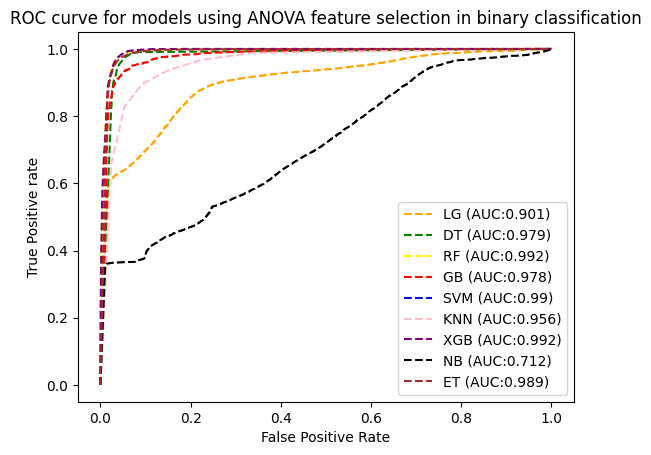

In [ ]:
fpr5 = 1093/(16434 + 1093)
tpr5 = 16726/(16726 + 847)
auc_score5 = 0.990
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='LG (AUC:'+str(round(auc_score1,3))+')')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='DT (AUC:'+str(round(auc_score2,3))+')')
plt.plot(fpr3, tpr3, linestyle='--',color='yellow', label='RF (AUC:'+str(round(auc_score3,3))+')')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='GB (AUC:'+str(round(auc_score4,3))+')')
plt.plot(fpr5, tpr5, linestyle='--',color='blue', label='SVM (AUC:'+str(round(auc_score5,3))+')')
plt.plot(fpr6, tpr6, linestyle='--',color='pink', label='KNN (AUC:'+str(round(auc_score6,3))+')')
plt.plot(fpr7, tpr7, linestyle='--',color='purple', label='XGB (AUC:'+str(round(auc_score7,3))+')')
plt.plot(fpr8, tpr8, linestyle='--',color='black', label='NB (AUC:'+str(round(auc_score8,3))+')')
plt.plot(fpr9, tpr9, linestyle='--',color='brown', label='ET (AUC:'+str(round(auc_score9,3))+')')

# title
plt.title('ROC curve for models using ANOVA feature selection in binary classification')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

# Multi-Label Classification (Family-Classification)

# Data Processing

In [ ]:
# select malicious rows of each type of attack
mul_data1 = data1.feature_0 == 1
mul_data2 = data2.feature_0 == 1
mul_data3 = data3.feature_0 == 1
mul_data4 = data4.feature_0 == 1
mul_data5 = data5.feature_0 == 1
mul_data6 = data6.feature_0 == 1
mul_data7 = data7.feature_0 == 1
mul_data8 = data8.feature_0 == 1
mul_data9 = data9.feature_0 == 1

In [ ]:
# label malicious rows with 1-9 for multi-label
data1.loc[mul_data1, "feature_0"] = 1
data2.loc[mul_data2, "feature_0"] = 2
data3.loc[mul_data3, "feature_0"] = 3
data4.loc[mul_data4, "feature_0"] = 4
data5.loc[mul_data5, "feature_0"] = 5
data6.loc[mul_data6, "feature_0"] = 6
data7.loc[mul_data7, "feature_0"] = 7
data8.loc[mul_data8, "feature_0"] = 8
data9.loc[mul_data9, "feature_0"] = 9

In [ ]:
# combine 9 types
df_mul = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9])
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
0,437.563571,1351.173440,164944.147470,704.662341,1346.377355,171567.380491,2015.481616,1340.104694,180591.333200,19696.823892,...,0.000000,14619.690111,1340.817992,426.244346,1340.817992,181684.242397,0.000000,0.000000,1,0
1,439.400772,1353.797591,169482.215618,664.787025,1349.365313,172807.896305,1778.983748,1345.597490,175424.792358,16934.947924,...,0.000000,27623.284974,1341.130387,425.505210,1341.130387,181054.683719,0.000000,0.000000,1,0
2,301.954598,1326.778917,195161.714632,516.156670,1328.096839,194734.903426,1627.891901,1333.284001,190191.966096,16808.639673,...,0.000000,27719.303452,1340.702953,426.233017,1340.702953,181674.584821,0.000000,0.000000,1,0
3,209.397726,1310.361807,134531.989365,330.110196,1307.842310,134119.008016,915.314652,1302.818197,136248.289802,8789.030170,...,0.000057,21963.740888,1227.110059,238.965895,1228.576780,57104.698984,0.977038,0.002521,1,0
4,374.712064,1337.501748,193072.940286,643.180734,1340.639453,188892.985689,1952.407728,1342.840191,183590.716111,19649.295311,...,0.000000,25070.859670,1341.077561,425.518245,1341.077561,181065.776502,0.000000,0.000000,1,0


## Reset the columns name

In [ ]:
df_mul.columns = ['feature_'+str(i) for i in range(len(df_mul.columns))]
df_mul.columns.values[0]='label'
df_mul.columns.values[-1]='attack'

cols = list(df_mul)[1:]
cols.append('label')
# reorder the columns
df_mul = df_mul[cols]

df_mul.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
0,437.563571,1351.173440,164944.147470,704.662341,1346.377355,171567.380491,2015.481616,1340.104694,180591.333200,19696.823892,...,0.000000,14619.690111,1340.817992,426.244346,1340.817992,181684.242397,0.000000,0.000000,1,0
1,439.400772,1353.797591,169482.215618,664.787025,1349.365313,172807.896305,1778.983748,1345.597490,175424.792358,16934.947924,...,0.000000,27623.284974,1341.130387,425.505210,1341.130387,181054.683719,0.000000,0.000000,1,0
2,301.954598,1326.778917,195161.714632,516.156670,1328.096839,194734.903426,1627.891901,1333.284001,190191.966096,16808.639673,...,0.000000,27719.303452,1340.702953,426.233017,1340.702953,181674.584821,0.000000,0.000000,1,0
3,209.397726,1310.361807,134531.989365,330.110196,1307.842310,134119.008016,915.314652,1302.818197,136248.289802,8789.030170,...,0.000057,21963.740888,1227.110059,238.965895,1228.576780,57104.698984,0.977038,0.002521,1,0
4,374.712064,1337.501748,193072.940286,643.180734,1340.639453,188892.985689,1952.407728,1342.840191,183590.716111,19649.295311,...,0.000000,25070.859670,1341.077561,425.518245,1341.077561,181065.776502,0.000000,0.000000,1,0


# Data Transformation

## Normalization

In [ ]:
# import required modules
from sklearn.preprocessing import MinMaxScaler

# create scaled DataFrame where each variable has mean of 0 and standard dev of 1
df_mul_scaled = MinMaxScaler().fit_transform(df_mul)

# view first five rows of scaled DataFrame
df_mul_scaled = pd.DataFrame(df_mul_scaled, columns=list(df_mul))
df_mul_scaled.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
0,0.058575,0.892166,0.342944,0.056699,0.907983,0.355463,0.054195,0.908095,0.378303,0.055623,...,0.582509,0.326445,0.918972,0.616127,0.918972,0.379612,0.554809,0.556257,0.0,0.0
1,0.058822,0.893968,0.352379,0.053486,0.910079,0.358033,0.047833,0.911967,0.367480,0.047823,...,0.582509,0.616824,0.919195,0.615058,0.919195,0.378297,0.554809,0.556257,0.0,0.0
2,0.040380,0.875414,0.405771,0.041510,0.895159,0.403463,0.043768,0.903286,0.398415,0.047466,...,0.582509,0.618968,0.918890,0.616110,0.918890,0.379592,0.554809,0.556257,0.0,0.0
3,0.027961,0.864140,0.279713,0.026519,0.880951,0.277875,0.024598,0.881808,0.285413,0.024818,...,0.582537,0.490442,0.837895,0.345420,0.838940,0.119315,0.554821,0.557429,0.0,0.0
4,0.050142,0.882778,0.401428,0.051745,0.903958,0.391359,0.052498,0.910023,0.384586,0.055488,...,0.582509,0.559826,0.919157,0.615077,0.919157,0.378320,0.554809,0.556257,0.0,0.0


In [ ]:
df_mul_scaled.shape

(117000, 117)

# Model Building (**Family**)


In [ ]:
from sklearn.preprocessing import LabelEncoder
# split the dataset into training and testing sets
X = df_mul_scaled.drop(['attack', 'label'], axis=1) # features
y = df_mul_scaled['label'] # target

lab_enc = LabelEncoder()
y = lab_enc.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55, stratify=y)

## Feature Selection

### SelectKBest

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2

# feature selection and engineering
selector = SelectKBest(f_classif, k=90)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

# Fit a Decision Tree on the training dataset(**Family**)

## Tuning

In [ ]:
# define the parameter grid to search over
param_grid = {
    'criterion':['gini'],
    'max_depth': [20],
    'min_samples_leaf': [9]
}

# create an instance of the model
dt = DecisionTreeClassifier()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 9}
Best score: 0.9031868131868132


## Fit Model 1

In [ ]:
from sklearn.metrics import roc_curve, auc
# create an instance of the model with the best parameters
best_dt = DecisionTreeClassifier(criterion='gini', max_depth=20, min_samples_leaf=9)

# train the model on the training data
best_dt.fit(X_train, y_train)

# calculate predictions on Model
y_pred_dt = best_dt.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)

# generate a detailed classification report
report = classification_report(y_test, y_pred_dt)
print("Classification Report:")
print(report)

# ROC curve
proba_dt_mul = best_dt.predict_proba(X_test)
fpr10, tpr10, threshold10 = roc_curve(y_test, proba_dt_mul[:,1], pos_label=1)

auc_score10 = auc(fpr10, tpr10)

Accuracy: 0.9021367521367522
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     17550
           1       0.96      0.97      0.97      1950
           2       0.96      0.97      0.96      1950
           3       0.92      0.92      0.92      1950
           4       0.47      0.34      0.39      1950
           5       0.48      0.64      0.54      1950
           6       0.99      1.00      1.00      1950
           7       0.90      0.91      0.91      1950
           8       0.98      0.98      0.98      1950
           9       0.94      0.94      0.94      1950

    accuracy                           0.90     35100
   macro avg       0.86      0.86      0.86     35100
weighted avg       0.90      0.90      0.90     35100



## Model 1 Report

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_dt)

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

print(FP)
print(FN)
print(TP)
print(TN)

[ 650.   77.   91.  137.  751. 1374.   17.  194.   51.  111.]
[ 835.   63.   54.  169. 1289.  704.    0.  179.   40.  120.]
[16715.  1887.  1896.  1781.   661.  1246.  1950.  1771.  1910.  1830.]
[16900. 33073. 33059. 33013. 32399. 31776. 33133. 32956. 33099. 33039.]


# Fit a Random Forest on the training dataset(**Family**)

## Tuning

In [ ]:
# define the parameter grid to search over
param_grid = {
    'criterion': ['gini'],
    'n_estimators': [90],
    'max_depth': [20]
}
# create an instance of the model
rf = RandomForestClassifier()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 90}
Best score: 0.908046398046398


## Fit Model 2

In [ ]:
# train and evaluate the model with the best hyperparameters
best_rf = RandomForestClassifier(criterion='gini', n_estimators=90, max_depth=20)

# train the model on the training data
best_rf.fit(X_train, y_train)

# calculate predictions on Model
y_pred_rf = best_rf.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

# generate a detailed classification report
report = classification_report(y_test, y_pred_rf)
print("Classification Report:")
print(report)

# ROC curve
proba_rf_mul = best_rf.predict_proba(X_test)
fpr11, tpr11, threshold11 = roc_curve(y_test, proba_rf_mul[:,1], pos_label=1)

auc_score11 = auc(fpr11, tpr11)

Accuracy: 0.9065811965811966
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     17550
           1       0.97      0.99      0.98      1950
           2       0.96      0.99      0.97      1950
           3       0.95      0.92      0.93      1950
           4       0.44      0.42      0.43      1950
           5       0.45      0.50      0.47      1950
           6       0.99      1.00      1.00      1950
           7       0.93      0.92      0.93      1950
           8       0.98      0.99      0.98      1950
           9       0.95      0.95      0.95      1950

    accuracy                           0.91     35100
   macro avg       0.86      0.86      0.86     35100
weighted avg       0.91      0.91      0.91     35100



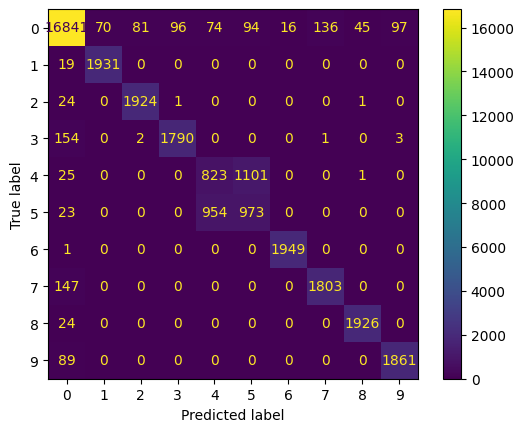

In [ ]:
cm_data = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_data)
disp_rf.plot()
plt.show()

## Model 2 Report

In [ ]:
rf_mul_data = multilabel_confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_mul_data)
disp_rf.plot()
plt.show()

[ 511.   71.   85.   97. 1041. 1119.   17.  140.   44.   98.]
[ 712.   18.   24.  161. 1064.  980.    0.  149.   29.   86.]
[16838.  1932.  1926.  1789.   886.   970.  1950.  1801.  1921.  1864.]
[17039. 33079. 33065. 33053. 32109. 32031. 33133. 33010. 33106. 33052.]


# Fit a Support Vector Machine on the training dataset(**Family**)

## Tuning

In [ ]:
from sklearn.svm import SVC

# define the parameter grid to search over
param_grid = {
    'C': [1000],
    'kernel': ['rbf'],
    'gamma': [3.0]
}

# create an instance of the model
svm = SVC()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

## Fit Model 3

In [ ]:
# train the model on the training data with the best hyperparameters
best_svm = SVC(C=1000, kernel='rbf', gamma=3.0, probability=True)
best_svm.fit(X_train, y_train)

# calculate predictions on Model
y_pred_svm = best_svm.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy)

# generate a detailed classification report
report = classification_report(y_test, y_pred_svm)
print("Classification Report:")
print(report)

# ROC curve
proba_svm_mul = best_svm.predict_proba(X_test)
fpr12, tpr12, threshold12 = roc_curve(y_test, proba_svm_mul[:,1], pos_label=1)

auc_score12 = auc(fpr12, tpr12)

Accuracy: 0.8971509971509971
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     17550
           1       0.96      0.99      0.97      1950
           2       0.95      0.98      0.96      1950
           3       0.94      0.89      0.92      1950
           4       0.47      0.40      0.43      1950
           5       0.48      0.58      0.52      1950
           6       0.99      1.00      1.00      1950
           7       0.89      0.90      0.90      1950
           8       0.94      0.96      0.95      1950
           9       0.96      0.90      0.93      1950

    accuracy                           0.90     35100
   macro avg       0.85      0.85      0.85     35100
weighted avg       0.90      0.90      0.90     35100



## Model 3 Report

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_svm)

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

print(FP)
print(FN)
print(TP)
print(TN)

[ 795.   71.  111.  121.  859. 1241.   12.  228.  111.   76.]
[8.810e+02 4.300e+01 4.800e+01 2.030e+02 1.178e+03 8.060e+02 1.000e+00
 1.940e+02 8.300e+01 1.880e+02]
[16669.  1907.  1902.  1747.   772.  1144.  1949.  1756.  1867.  1762.]
[16755. 33079. 33039. 33029. 32291. 31909. 33138. 32922. 33039. 33074.]


# Fit a kNN on the training dataset(**Family**)

## Tuning

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# define the parameter grid to search over
param_grid = {
    'n_neighbors': [6]
}

# create a KNeighborsClassifier object
knn = KNeighborsClassifier()

# use grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# print the best hyperparameters and their corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'n_neighbors': 6}
Best score: 0.8381562881562882


## Fit Model 4

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# use the best hyperparameters to train a new KNeighborsClassifier
best_knn = KNeighborsClassifier(n_neighbors=6)

# fit the model to the training data
best_knn.fit(X_train, y_train)

# make predictions on the test data
y_pred_kNN = best_knn.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred_kNN)
print("Accuracy:", accuracy)

# generate a detailed classification report
report = classification_report(y_test, y_pred_kNN)
print("Classification Report:")
print(report)

# ROC curve
proba_knn_mul = best_knn.predict_proba(X_test)
fpr13, tpr13, threshold13 = roc_curve(y_test, proba_knn_mul[:,1], pos_label=1)

print(fpr13)
print(tpr13)
auc_score13 = auc(fpr13, tpr13)

Accuracy: 0.8462962962962963
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     17550
           1       0.95      0.83      0.88      1950
           2       0.83      0.78      0.80      1950
           3       0.82      0.85      0.84      1950
           4       0.47      0.60      0.53      1950
           5       0.46      0.36      0.40      1950
           6       0.99      1.00      1.00      1950
           7       0.90      0.82      0.86      1950
           8       0.84      0.94      0.89      1950
           9       0.93      0.85      0.89      1950

    accuracy                           0.85     35100
   macro avg       0.81      0.79      0.80     35100
weighted avg       0.85      0.85      0.85     35100

[0.00000000e+00 5.42986425e-04 1.14630468e-03 2.68476621e-03
 6.00301659e-03 1.30618401e-02 2.90196078e-02 1.00000000e+00]
[0.         0.63333333 0.75128205 0.82461538 0.87897436 0.93333333

## Model 4 Report

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_kNN)

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

print(FP)
print(FN)
print(TP)
print(TN)

[1886.   83.  354.  356. 1306.  816.   18.  186.  360.  123.]
[1.587e+03 3.500e+02 4.520e+02 2.830e+02 7.870e+02 1.249e+03 1.000e+00
 3.620e+02 1.160e+02 3.010e+02]
[15963.  1600.  1498.  1667.  1163.   701.  1949.  1588.  1834.  1649.]
[15664. 33067. 32796. 32794. 31844. 32334. 33132. 32964. 32790. 33027.]


# Fit a Naive Bayes on the training dataset(**Family**)

## Tuning

In [ ]:
# define the parameter grid to search over
param_grid = {
    'priors': [None],
    'var_smoothing': [0.1]
}

# create an instance of model
nb=GaussianNB()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'priors': None, 'var_smoothing': 0.1}
Best score: 0.31335775335775334


## Fit Model 5

In [ ]:
# use the best hyperparameters to train a new Naive Bayes Classifier
best_nb = GaussianNB(var_smoothing=0.1)

# fit the model to the training data
best_nb.fit(X_train, y_train)

# make predictions on the test data
y_pred_nb = best_nb.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred_nb)
print("Accuracy:", accuracy)

# generate a detailed classification report
report = classification_report(y_test, y_pred_nb)
print("Classification Report:")
print(report)

# ROC curve
proba_nb_mul = best_nb.predict_proba(X_test)
fpr14, tpr14, threshold14 = roc_curve(y_test, proba_nb_mul[:,1], pos_label=1)
auc_score14 = auc(fpr14, tpr14)

Accuracy: 0.3071225071225071
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.22      0.35     17550
           1       0.03      0.02      0.03      1950
           2       0.10      0.01      0.01      1950
           3       0.02      0.03      0.03      1950
           4       0.47      0.99      0.64      1950
           5       0.00      0.00      0.00      1950
           6       1.00      0.99      0.99      1950
           7       0.19      0.39      0.26      1950
           8       0.11      0.12      0.11      1950
           9       0.14      0.99      0.24      1950

    accuracy                           0.31     35100
   macro avg       0.29      0.38      0.27     35100
weighted avg       0.53      0.31      0.30     35100



## Model 5 Report

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_nb)

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

print(FP)
print(FN)
print(TP)
print(TN)

[7.4300e+02 1.7850e+03 9.1000e+01 2.1800e+03 2.1310e+03 1.0400e+02
 8.0000e+00 3.0530e+03 2.0230e+03 1.1968e+04]
[13575.  1903.  1940.  1897.    27.  1950.    23.  1203.  1554.    14.]
[3975.   47.   10.   53. 1923.    0. 1927.  747.  396. 1936.]
[16807. 31365. 33059. 30970. 31019. 33046. 33142. 30097. 31127. 21182.]


# Model Evaluation

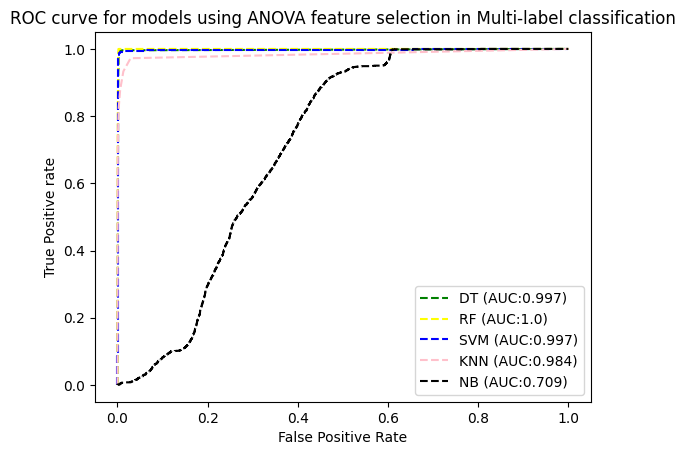

In [ ]:
plt.plot(fpr10, tpr10, linestyle='--',color='green', label='DT (AUC:'+str(round(auc_score10,3))+')')
plt.plot(fpr11, tpr11, linestyle='--',color='yellow', label='RF (AUC:'+str(round(auc_score11,3))+')')
plt.plot(fpr12, tpr12, linestyle='--',color='blue', label='SVM (AUC:'+str(round(auc_score12,3))+')')
plt.plot(fpr13, tpr13, linestyle='--',color='pink', label='KNN (AUC:'+str(round(auc_score13,3))+')')
plt.plot(fpr14, tpr14, linestyle='--',color='black', label='NB (AUC:'+str(round(auc_score14,3))+')')

# title
plt.title('ROC curve for models using ANOVA feature selection in Multi-label classification')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();